# Анализ взаимодействия пользователей с карточками Яндекс.Дзен

Я аналитик в Яндекс.Дзене. Почти все мое время занимает анализ пользовательского взаимодействия с карточками статей. 

Каждую неделю начинающие менеджеры Денис и Валерия задают мне одни и те же вопросы:
- Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
- Как много карточек генерируют источники с разными темами?
- Как соотносятся темы карточек и темы источников?

Я решил, что процесс пора автоматизировать. Для Дениса и Валерии нужно сделать дашборд. Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу. Пайплайн для меня уже разработали дата-инженеры, за что им большое спасибо. 

Я пообщался с менеджерами и администраторами баз данных, что привело к созданию конкретного ТЗ. Макет дашборда будет выглядеть следующим образом:

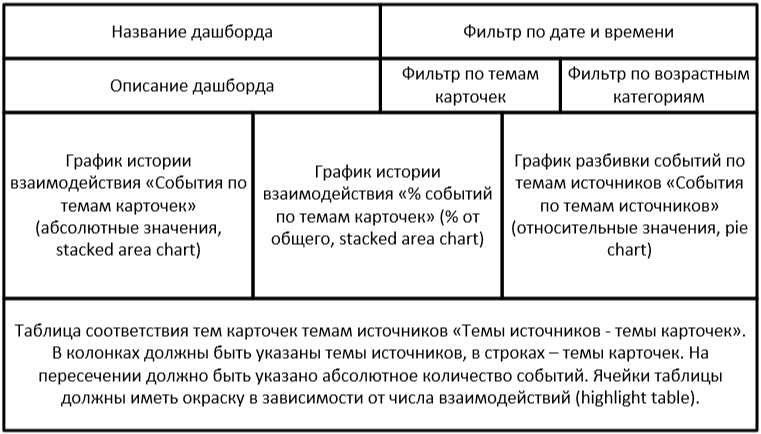

**Цель проекта** — создание дашборда для менеджеров о взаимодействии пользователей с карточками Яндекс.Дзен, который будет отвечать в режиме онлайн на их вопросы. 

## Запрос к базам и подготовка данных

Импортируем нужные библиотеки и создадим функцию с sql-запросом.

In [1]:
import pandas as pd
!pip install psycopg2
import psycopg2
from sqlalchemy import create_engine

db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

def select(sql):
    return pd.io.sql.read_sql(sql, con = engine)

sql = ''' SELECT * FROM dash_visits '''

     ---------------------------------------- 1.2/1.2 MB 549.0 kB/s eta 0:00:00


Выгрузим данные в файл и выведем 10 первых строк таблицы.

In [2]:
df = select(sql)
df.to_csv('dash_visits.csv', sep = ';', index = False)
df.head(10)

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
5,1040602,Деньги,Авто,18-25,2019-09-24 18:57:00,22
6,1040603,Деньги,Авто,18-25,2019-09-24 18:58:00,24
7,1040604,Деньги,Авто,18-25,2019-09-24 18:59:00,20
8,1040605,Деньги,Авто,18-25,2019-09-24 19:00:00,5
9,1040606,Деньги,Авто,26-30,2019-09-24 18:29:00,1


Изучим общую информацию по имеющимся данным.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df['dt'].min()

Timestamp('2019-09-24 18:28:00')

In [6]:
df['dt'].max()

Timestamp('2019-09-24 19:00:00')

Видим, что:
- таблица из файла `dash_visits.csv` содержит 6 столбцов, их названия соответствуют «змеиному регистру»;
- типы данных: `datetime`, `int` и `object`;
- всего 30745 строк;
- пропущенных данных и дубликатов нет;
- у нас данные за 24 сентября в период с 18:28 до 19:00.

## Ответы на вопросы

Ответим на вопросы менеджеров, о которых говорили в начале.

---

### 1. Cколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?

Выясним, сколько всего было взаимодействий с карточками, в том числе в долевом соотношении по темам.

In [7]:
df['visits'].sum()

310207

In [8]:
item_topic = df.groupby('item_topic').agg({'visits':'sum'}).reset_index()
item_topic['proportion'] = item_topic['visits'] / item_topic['visits'].sum()
item_topic.sort_values(by = 'proportion', ascending = False).style.format({'proportion': '{:.2f}%'})

,item_topic,visits,proportion
11,Наука,21736,0.07%
13,Отношения,20666,0.07%
6,Интересные факты,19942,0.06%
12,Общество,19640,0.06%
14,Подборки,17772,0.06%
19,Россия,16966,0.05%
15,Полезные советы,15435,0.05%
8,История,15389,0.05%
20,Семья,11897,0.04%
3,Женщины,11499,0.04%


Всего было 310207 взаимодействий пользователей с карточками за 24 сентября в период с 18:28 до 19:00, по 25 темам.

Наиболее популярные темы:
- `наука` с 21736 взаимодействиями и 7% от общего числа;
- `отношения` с 20666 взаимодействиями и 7% от общего числа;
- `интересные факты` с 19942 взаимодействиями и 6% от общего числа.

Наименее популярные темы:
- `знаменитости` с 7394 взаимодействиями и 2% от общего числа;
- `шоу` с 7511 взаимодействиями и 2% от общего числа;
- `женская психология` с 7737 взаимодействиями и 2% от общего числа.

### 2. Как много карточек генерируют источники с разными темами?

Выясним, как много карточек генерируют источники с разными темами. 

In [9]:
source_topic = df.groupby('source_topic').agg({'visits':'sum'}).reset_index()
source_topic['proportion'] = source_topic['visits'] / source_topic['visits'].sum()
source_topic.sort_values(by = 'proportion', ascending = False).style.format({'proportion': '{:.2f}%'})

,source_topic,visits,proportion
20,Семейные отношения,33309,0.11%
17,Россия,29831,0.10%
12,Полезные советы,27412,0.09%
15,Путешествия,24124,0.08%
5,Знаменитости,23945,0.08%
9,Кино,20084,0.06%
2,Дети,15243,0.05%
8,История,14628,0.05%
21,Семья,13896,0.04%
4,Здоровье,12831,0.04%


Наибольшее количество карточек генерируют такие темы, как:
- `семейные отношения`, так как имеет 33309 взаимодействий, что является 11% от общего числа;
- `Россия`, так как имеет 29831 взаимодействий, что является 10% от общего числа;
- `полезные советы`, так как имеет 27412 взаимодействий, что является 9% от общего числа.

Наименьшее количество карточек генерируют такие темы, как:
- `финансы`, так как имеет 2628 взаимодействий, что является 1% от общего числа;
- `музыка`, так как имеет 2869 взаимодействий, что является 1% от общего числа;
- `строительство`, так как имеет 3000 взаимодействий, что является 1% от общего числа.

### 3. Как соотносятся темы карточек и темы источников?

Наиболее часто посещаемые карточки с темой `рассказы` источника `путешествия` - 4587 событий, `общество` источника `Россия` - 3471 событий и `наука` источника `кино` - 3279 событий. 

Если смотреть на источники, у которых наибольшее количество популярных тем, то лидерами являются:
- `Россия` с темами: `общество, отношения, Россия, интересные факты, знаменитости, наука, скандалы`;
- `полезные советы` с темами: `здоровье, отношения, подборки, дети, интересные факты, наука`;
- `путешествия` с темами: `история, рассказы, наука, полезные советы`. 

На дашборде видно, как эти соприкосновения выделяются более темным цветом. 